In [1]:
!pip install pillow stegano
import os
import tkinter as tk
from tkinter import filedialog, messagebox, simpledialog
from PIL import Image, ImageTk
from stegano.lsb import hide, reveal

Defaulting to user installation because normal site-packages is not writeable


In [2]:
root = tk.Tk()
root.title("Image Steganography")
root.geometry("600x400")
root.config(bg="lightgray")

In [3]:
def encode_message():
    file_path = filedialog.askopenfilename(title="Select Image", filetypes=[
        ("Image Files", "*.png;*.jpg;*.jpeg;*.bmp")
    ])
    if not file_path:
        return

    message = simpledialog.askstring("Input Message", "Enter the secret message:")
    if not message:
        return

    output_path = filedialog.asksaveasfilename(defaultextension=".png", filetypes=[
        ("PNG Files", "*.png"),
        ("JPEG Files", "*.jpg;*.jpeg"),
        ("Bitmap Files", "*.bmp")
    ])
    if not output_path:
        return

    if not output_path.lower().endswith(".png"):
        output_path += ".png"

    try:
        secret_image = hide(file_path, message)  # Hides message inside the image
        secret_image.save(output_path)  # Save the encoded image
        messagebox.showinfo("Success", f"Message encoded successfully!\nSaved as: {output_path}")
    except Exception as e:
        messagebox.showerror("Error", f"Encoding failed: {str(e)}")


In [4]:
def decode_message():
    file_path = filedialog.askopenfilename(title="Select Encoded Image", filetypes=[
        ("Image Files", "*.png;*.jpg;*.jpeg;*.bmp")
    ])
    if not file_path:
        return

    try:
        decoded_message = reveal(file_path)  # Extract the hidden message
        if decoded_message:
            messagebox.showinfo("Decoded Message", f"Hidden message:\n{decoded_message}")
        else:
            messagebox.showwarning("No Hidden Message", "No hidden message found in the image.")
    except Exception as e:
        messagebox.showerror("Error", f"Decoding failed: {str(e)}")


In [5]:
encode_btn = tk.Button(root, text="Encode Message", command=encode_message, width=20, bg="lightblue")
encode_btn.pack(pady=10)

decode_btn = tk.Button(root, text="Decode Message", command=decode_message, width=20, bg="lightgreen")
decode_btn.pack(pady=10)


In [ ]:
root.mainloop()

In [7]:
import os
import cv2
import numpy as np

In [8]:
stego_folder = "C:/Users/DELL/Downloads/archive (1)/Stego-pvd-dataset/train/stegoTrain"
clean_folder = "C:/Users/DELL/Downloads/archive (1)/Stego-pvd-dataset/train/cleanTrain"

In [9]:
images = []
labels = []

In [10]:
img_size = (128, 128)

# Function to load images from a folder
def load_images_from_folder(folder, label):
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(label)

# Load stego images with label 1
load_images_from_folder(stego_folder, label=1)

# Load clean images with label 0
load_images_from_folder(clean_folder, label=0)

# Convert to NumPy arrays
images = np.array(images)
labels = np.array(labels)

print(f"Total images loaded: {len(images)}")
print(f"Image shape: {images[0].shape}")
print(f"Labels distribution: {np.bincount(labels)}")

Total images loaded: 4050
Image shape: (128, 128, 3)
Labels distribution: [  55 3995]


In [11]:
# Flatten the image data for SVM
X = images.reshape(images.shape[0], -1)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42, stratify=labels)

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
from sklearn.decomposition import PCA

In [17]:
# Apply PCA to reduce dimensions
pca = PCA(n_components=100)  # Reduce to 100 features
X_pca = pca.fit_transform(X_scaled)

In [18]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, labels, test_size=0.2, random_state=42, stratify=labels
)

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [20]:
# Initialize and train the SVM model
# We're using a linear kernel with default regularization
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_pca, y_train_pca)

# Make predictions on the test set
y_pred_pca = svm_model.predict(X_test_pca)

In [21]:
#  Evaluate the model performance
print(f"\nSVM Accuracy with PCA: {accuracy_score(y_test_pca, y_pred_pca) * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test_pca, y_pred_pca))
print("Confusion Matrix:\n", confusion_matrix(y_test_pca, y_pred_pca))


SVM Accuracy with PCA: 97.65%

Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.64      0.42        11
           1       0.99      0.98      0.99       799

    accuracy                           0.98       810
   macro avg       0.66      0.81      0.71       810
weighted avg       0.99      0.98      0.98       810

Confusion Matrix:
 [[  7   4]
 [ 15 784]]


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

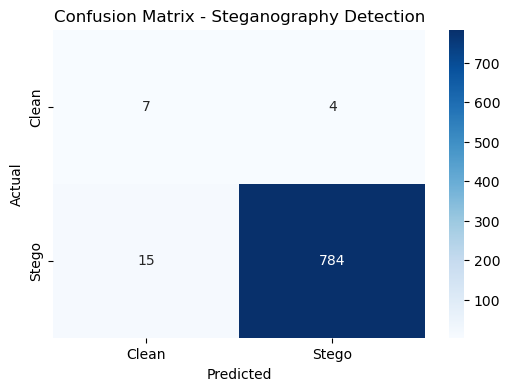

In [23]:
cm = confusion_matrix(y_test_pca, y_pred_pca)
class_names = ['Clean', 'Stego']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Steganography Detection')
plt.show()

In [24]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [25]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [26]:
# Preprocessing for CNN
images = images / 255.0  # Normalize
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

In [27]:
# One-hot encode labels for classification
y_train_cnn = to_categorical(y_train_cnn)
y_test_cnn = to_categorical(y_test_cnn)

In [28]:
 #Define Encoder
input_img = Input(shape=(128, 128, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [29]:
# Define Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

reconstructed = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='reconstructed')(x)

In [30]:
# Classifier Branch
flat = Flatten()(encoded)
fc = Dense(64, activation='relu')(flat)
drop = Dropout(0.5)(fc)
output_class = Dense(2, activation='softmax', name='classification')(drop)

In [31]:
# Build and Compile Model
model = Model(inputs=input_img, outputs=[reconstructed, output_class])
model.compile(
    optimizer='adam',
    loss={'reconstructed': 'mse', 'classification': 'categorical_crossentropy'},
    metrics={'classification': 'accuracy'}
)

In [32]:
# Train the Model
history = model.fit(
    X_train_cnn,
    {'reconstructed': X_train_cnn, 'classification': y_train_cnn},
    epochs=10,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - classification_accuracy: 0.9664 - classification_loss: 0.1731 - loss: 0.2633 - reconstructed_loss: 0.0902 - val_classification_accuracy: 0.9877 - val_classification_loss: 0.0437 - val_loss: 0.0614 - val_reconstructed_loss: 0.0148
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - classification_accuracy: 0.9836 - classification_loss: 0.0565 - loss: 0.0707 - reconstructed_loss: 0.0141 - val_classification_accuracy: 0.9938 - val_classification_loss: 0.0158 - val_loss: 0.0240 - val_reconstructed_loss: 0.0097
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - classification_accuracy: 0.9918 - classification_loss: 0.0191 - loss: 0.0279 - reconstructed_loss: 0.0088 - val_classification_accuracy: 0.9969 - val_classification_loss: 0.0066 - val_loss: 0.0131 - val_reconstructed_loss: 0.0067
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - classification_accuracy: 0.9923 - classification_loss: 0.0180 - loss: 0.0253 - reconstructed_loss:

In [33]:
metrics = model.evaluate(X_test_cnn, {'reconstructed': X_test_cnn, 'classification': y_test_cnn}, return_dict=True)
print(f"\nTest Accuracy (Classification): {metrics['classification_accuracy'] * 100:.2f}%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 491ms/step - classification_accuracy: 1.0000 - classification_loss: 6.7443e-04 - loss: 0.0056 - reconstructed_loss: 0.0049

Test Accuracy (Classification): 100.00%


In [34]:
# Actual labels (if one-hot encoded, convert to integer)
if y_test_cnn.ndim > 1:
    y_true_cnn = np.argmax(y_test_cnn, axis=1)
else:
    y_true_cnn = y_test_cnn

In [36]:
# Predict
y_pred_probs = model.predict(X_test_cnn)[1]
y_pred = np.argmax(y_pred_probs, axis=1)

# Print classification metrics
print("\nClassification Report:\n", classification_report(y_test_pca, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_pca, y_pred))

26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 479ms/step

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00       799

    accuracy                           1.00       810
   macro avg       1.00      1.00      1.00       810
weighted avg       1.00      1.00      1.00       810

Confusion Matrix:
 [[ 11   0]
 [  0 799]]


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

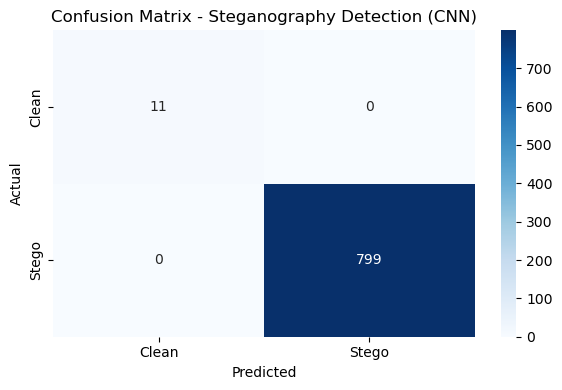

In [39]:
# Confusion matrix
cm = confusion_matrix(y_test_pca, y_pred)

# Class names
class_names = ['Clean', 'Stego']

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Steganography Detection (CNN)')
plt.tight_layout()
plt.show()